In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Code to load in my CSV (Comma separated values) file
df = pd.read_csv('/content/motor_data.csv')
print(df.head(50))  # data structure matches MATLAB

    Time_s          RPM  Vibration_g  Temperature_C
0        0  1501.811693     0.027954      44.271620
1        1  1500.542502     0.022632      43.347623
2        2  1506.877537     0.021324      45.552023
3        3  1486.065927     0.018032      45.919595
4        4  1514.253657     0.009118      44.564987
5        5  1491.061488     0.014022      46.592246
6        6  1500.377647     0.021827      41.963955
7        7  1496.364307     0.032062      42.850166
8        8  1501.495565     0.023701      38.855669
9        9  1480.554819     0.021549      46.042814
10      10  1515.238949     0.017290      43.017953
11      11  1505.458102     0.020611      44.493749
12      12  1520.099275     0.024811      47.018531
13      13  1514.166707     0.018730      45.102024
14      14  1500.114807     0.029459      44.119134
15      15  1490.609507     0.013899      43.303061
16      16  1482.610916     0.018119      44.519258
17      17  1500.169710     0.020262      46.205859
18      18  

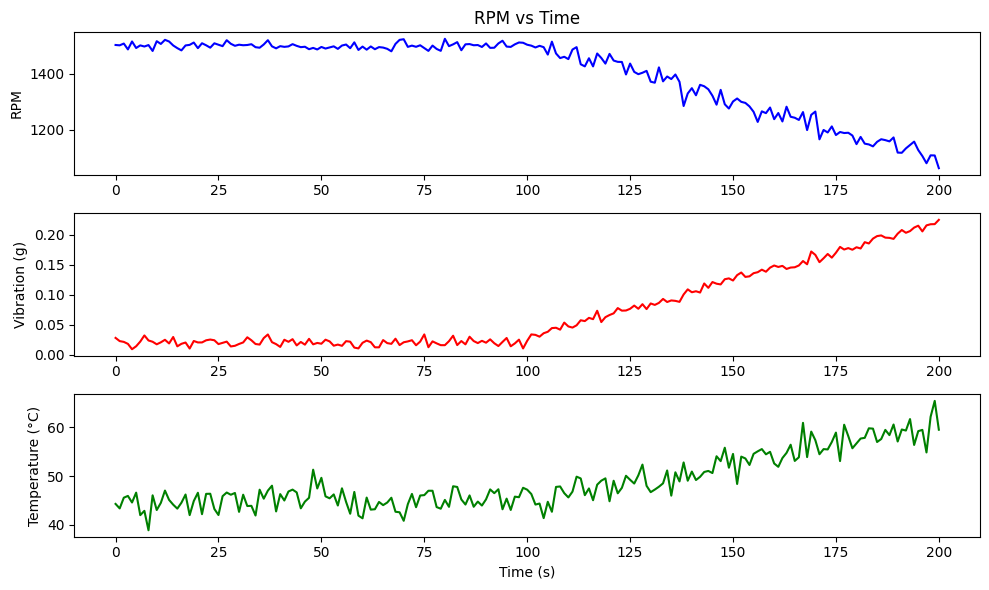

In [2]:
plt.figure(figsize=(10, 6))

# RPM data plot
plt.subplot(3, 1, 1)
plt.plot(df['Time_s'], df['RPM'], 'b-')
plt.ylabel('RPM')
plt.title('RPM vs Time')

# Vibration data plot
plt.subplot(3, 1, 2)
plt.plot(df['Time_s'], df['Vibration_g'], 'r-')
plt.ylabel('Vibration (g)')

# Temperature data plot
plt.subplot(3, 1, 3)
plt.plot(df['Time_s'], df['Temperature_C'], 'g-')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')

plt.tight_layout()
plt.show()

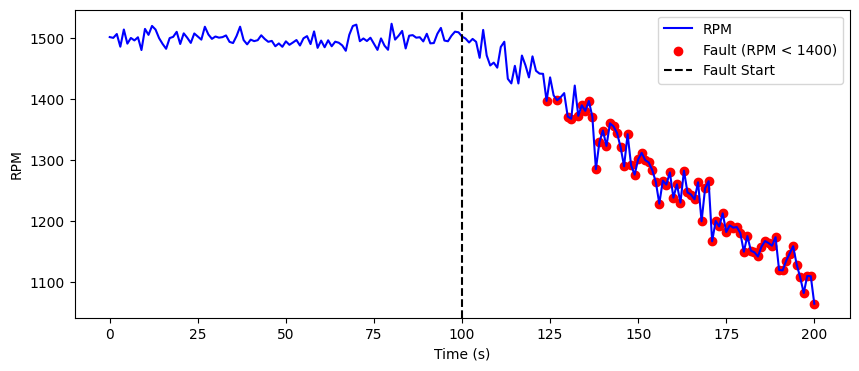

In [14]:
# Flag samples where RPM < 1400 (Note that error injection starts at 100s)
df['Fault'] = df['RPM'] < 1400

# Plot RPM with fault zone
plt.figure(figsize=(10, 4))
plt.plot(df['Time_s'], df['RPM'], 'b-', label='RPM')
plt.scatter(df[df['Fault']]['Time_s'], df[df['Fault']]['RPM'],
            color='red', label='Fault (RPM < 1400)')
plt.axvline(x=100, color='k', linestyle='--', label='Fault Start')
plt.xlabel('Time (s)'); plt.ylabel('RPM'); plt.legend()
plt.show()

In [15]:
from scipy import stats

# Detect RPM drop using Z-score (threshold = 2 standard deviations, Note std = Standard deviation)
rpm_mean = df['RPM'].mean()
rpm_std = df['RPM'].std()
df['RPM_Zscore'] = (df['RPM'] - rpm_mean) / rpm_std
df['Fault_Z'] = df['RPM_Zscore'] < -2  # Significant drop

# Print fault start time(Note Uses the ENTIRE dataset's average, including post-fault data)
# It misses the initial fault because it's comparing against data that already includes the fault
fault_time = df[df['Fault_Z']]['Time_s'].min()
print(f"Fault detected at t = {fault_time} seconds")

Fault detected at t = 190 seconds


In [16]:
from scipy import stats
import numpy as np

# Calculate rolling mean and std (window = 20 points to smooth noise)
# Only looks at the last 20 seconds of data ("local normal")
window = 20
df['RPM_rolling_mean'] = df['RPM'].rolling(window=window).mean()
df['RPM_rolling_std'] = df['RPM'].rolling(window=window).std()

# Z-score based on rolling statistics (not global mean!)
df['RPM_Zscore'] = (df['RPM'] - df['RPM_rolling_mean']) / df['RPM_rolling_std']

# Flag points where Z-score < -2 (significant drop)
df['Fault_Z'] = df['RPM_Zscore'] < -2

# Get the FIRST fault time (instead of min)
fault_time = df[df['Fault_Z']]['Time_s'].iloc[0] if df['Fault_Z'].any() else None
print(f"Fault detected at t = {fault_time} seconds")

Fault detected at t = 105 seconds


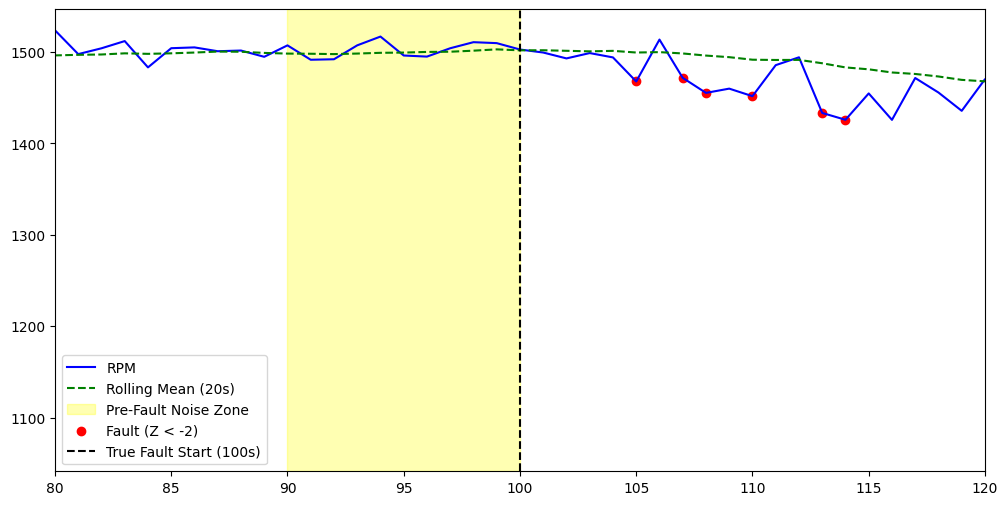

In [17]:
# Plot rolling mean and Z-score
# Like a smart sensor that notices unusual vibrations right when they start, it enable early detection of potential faults.
plt.figure(figsize=(12, 6))
plt.plot(df['Time_s'], df['RPM'], 'b-', label='RPM')
plt.plot(df['Time_s'], df['RPM_rolling_mean'], 'g--', label='Rolling Mean (20s)')
plt.axvspan(90, 100, color='yellow', alpha=0.3, label='Pre-Fault Noise Zone')
plt.scatter(df[df['Fault_Z']]['Time_s'], df[df['Fault_Z']]['RPM'],
            color='red', label='Fault (Z < -2)')
plt.axvline(x=100, color='k', linestyle='--', label='True Fault Start (100s)')
plt.xlim(80, 120)  # Zoom in near the fault
plt.legend()
plt.show()

In [9]:
from google.colab import files
files.download('motor_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')